### pip Install

In [1]:
!pip install monai
!pip install pydicom
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg
!pip install pylibjpeg-libjpeg

### Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import cv2
import re
import gc
from tqdm import tqdm
import pydicom as dicom
import shutil

"""import pydicom.pixel_data_handlers.gdcm_handler as gdcm_handler
dicom.config.image_handlers = [None, gdcm_handler]
from pydicom.config import image_handlers
image_handlers[1].have_pillow_jpeg2000_plugin = False"""

import nibabel as nib
from monai.transforms import Resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# for saving csv file only
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
import cv2
import re
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Configs

In [4]:
KAGGLE = True
IMG_SIZE = 512
CLASS = 7 # final outputs: background , C1, C2, C3, ..., C7

In [5]:
if KAGGLE:
    base_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
    save_path = '/kaggle/working'
else:
    base_path = '/content/drive/MyDrive/Colab_Notebooks/rsna-2022-cervical-spine-fracture-detection'
    save_path = '/content/drive/MyDrive/Colab_Notebooks/3_channel_preprocessed_dataset'
    
train_path = f'{base_path}/train_images'
segmentation_path = f'{base_path}/segmentations'

save_train_path = f'{save_path}/prep_train'
save_seg_path = f'{save_path}/prep_seg'
save_zip_path = f'{save_path}/zip'

train_df = pd.read_csv(f"{base_path}/train.csv")
ss_df = pd.read_csv(f"{base_path}/sample_submission.csv")
seg_df = pd.DataFrame({'mask_file': os.listdir(segmentation_path)})

seg_df['StudyInstanceUID'] = seg_df['mask_file'].apply(lambda x: x[:-4])
seg_df['mask_file'] = seg_df['mask_file'].apply(lambda x: os.path.join(base_path, 'segmentations', x))
df = train_df.merge(seg_df, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(base_path, 'train_images', x))
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)
df_seg['fold'] = -1

seg_revert = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

## Drop Bad Scans

https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344862

1. 1.2.826.0.1.3680043.20574: does not include a full cervical spine and should be ignored.
1. 1.2.826.0.1.3680043.29952: the slices are duplicated, meaning that there are 2 scans stiched to each other.

### Loads

In [6]:
def load_dicom(path, size=IMG_SIZE):
    levels = [400, 600, 700]
    windows = [1800, 2800, 4000]
    path = sorted(path, key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
    
    depth_img = []
    for filename in path:
        windowed_img = []
        for idx, level in enumerate(levels):
            window = windows[idx]
            maximum = level + window/2
            minimum = level - window/2
            
            img = dicom.read_file(filename)
            img = img.pixel_array
            img = img.clip(minimum, maximum)
            img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
            img = img - np.min(img)
            img = img / (np.max(img) + 1e-4)
            img = (img * 255).astype(np.uint16)

            windowed_img.append(img)
        depth_img.append(windowed_img)
        del(windowed_img)
    
    # image orientation: (depth, width, height, channel)
    img = np.asarray(depth_img).transpose(0, 2, 3, 1)
    del(depth_img)
    
    return img

In [7]:
def load_nii(path, StudyInstanceUID, tot_class=CLASS, size=IMG_SIZE):
    seg = nib.load(path).get_fdata() # convert to numpy array
    seg = seg[:, ::-1, ::-1].transpose(1, 0, 2)
    shape = seg.shape

    # when in revert list, set different for loop condition
    if StudyInstanceUID in seg_revert:
        condition = range(shape[2]-1, -1, -1)
    else:
        condition = range(shape[2])

    masked = []
    for idx in condition: # for each depth
        each_seg = seg[:, :, idx]
        each_seg = cv2.resize(each_seg, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        each_seg = each_seg.astype(np.uint16) * 255
        
        mask_7_class = []
        for cl in range(tot_class):
            mask_7_class.append(each_seg)

        masked.append(mask_7_class)
        del(mask_7_class)

    mask = np.asarray(masked)
    del(masked)

    # image orientation: (depth, width, height, channel)
    return mask.transpose(0, 2, 3, 1)

### Test image print

In [8]:
def print_img(image, mask, idx=120):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1); plt.imshow(image[idx]); plt.axis('OFF');
    plt.subplot(1, 3, 2); plt.imshow(mask[idx]); plt.axis('OFF');
    plt.subplot(1, 3, 3); plt.imshow(image[idx]); plt.imshow(mask[idx], alpha=0.5); plt.axis('OFF');
    plt.tight_layout()
    plt.show()

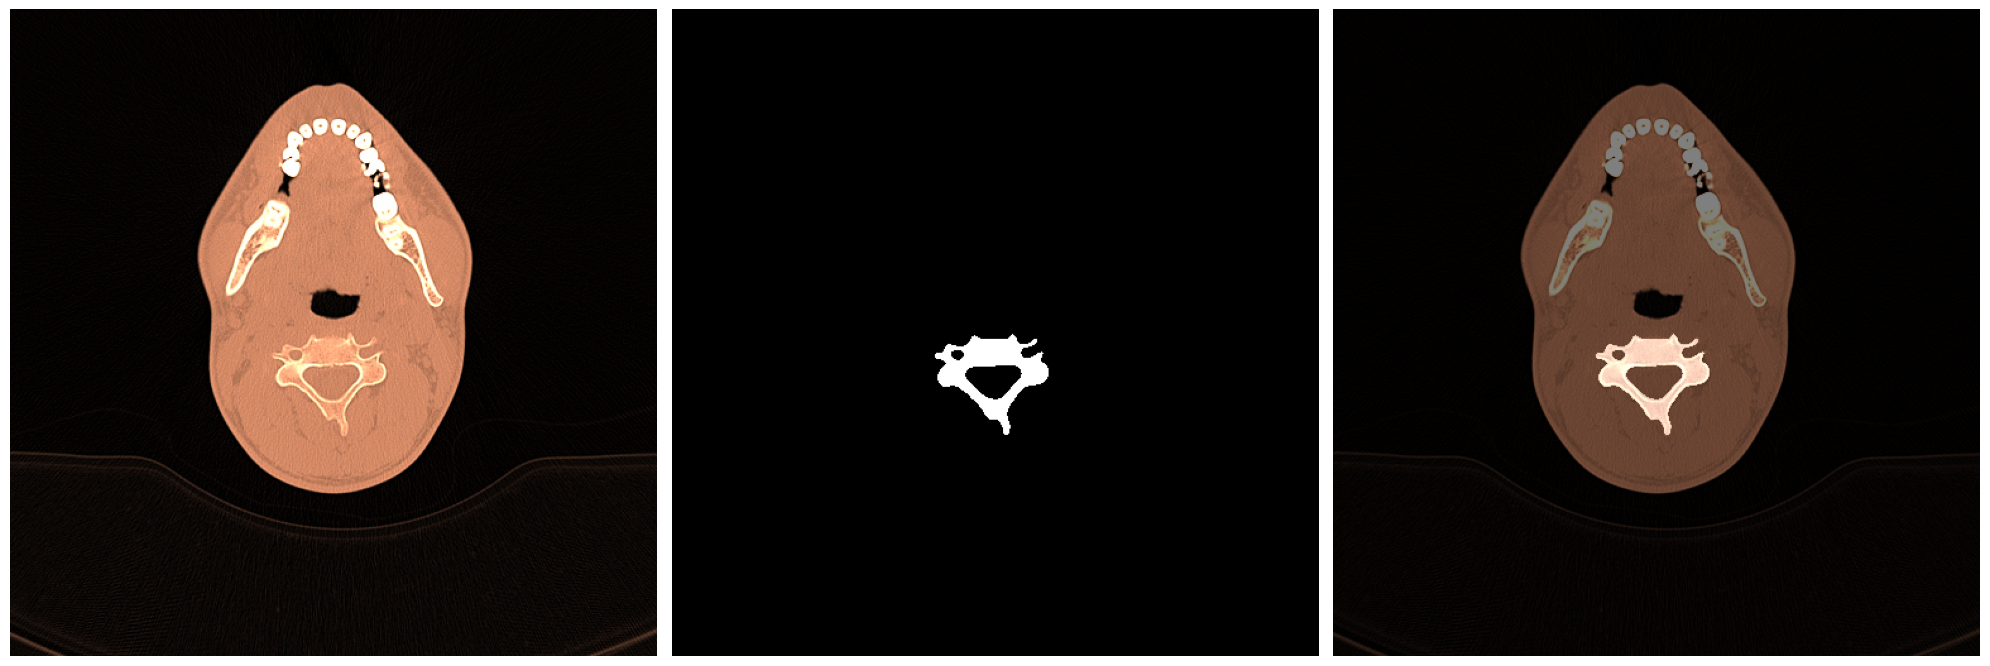

In [9]:
UID = '1.2.826.0.1.3680043.1363'
path_train = glob(f'{train_path}/{UID}/*')
path_seg = f'{segmentation_path}/{UID}.nii'

# convert train images
image = load_dicom(path_train)
# convert segmentation images
mask = load_nii(path_seg, UID, 3) # channel 3 to test printing
print_img(image, mask)

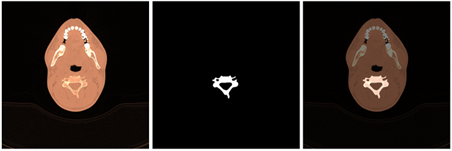

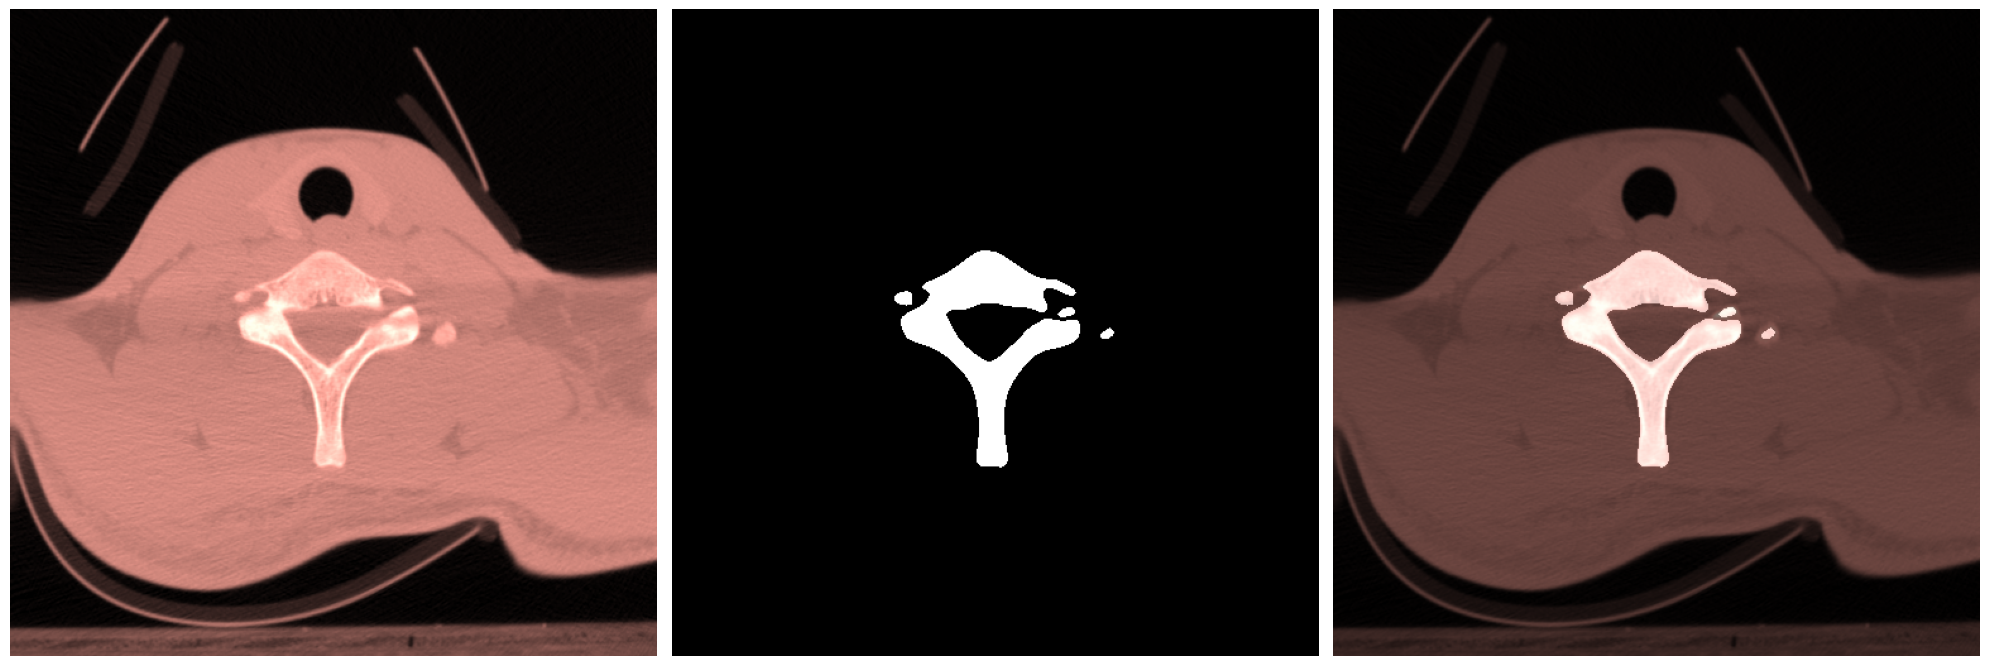

In [10]:
UID = '1.2.826.0.1.3680043.2243'
path_train = glob(f'{train_path}/{UID}/*')
path_seg = f'{segmentation_path}/{UID}.nii'

# convert train images
image = load_dicom(path_train)
# convert segmentation images
mask = load_nii(path_seg, UID, 3) # channel 3 to test printing
print_img(image, mask)

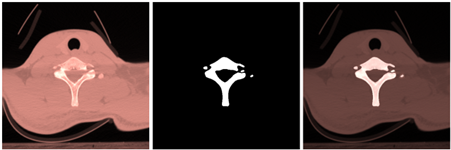

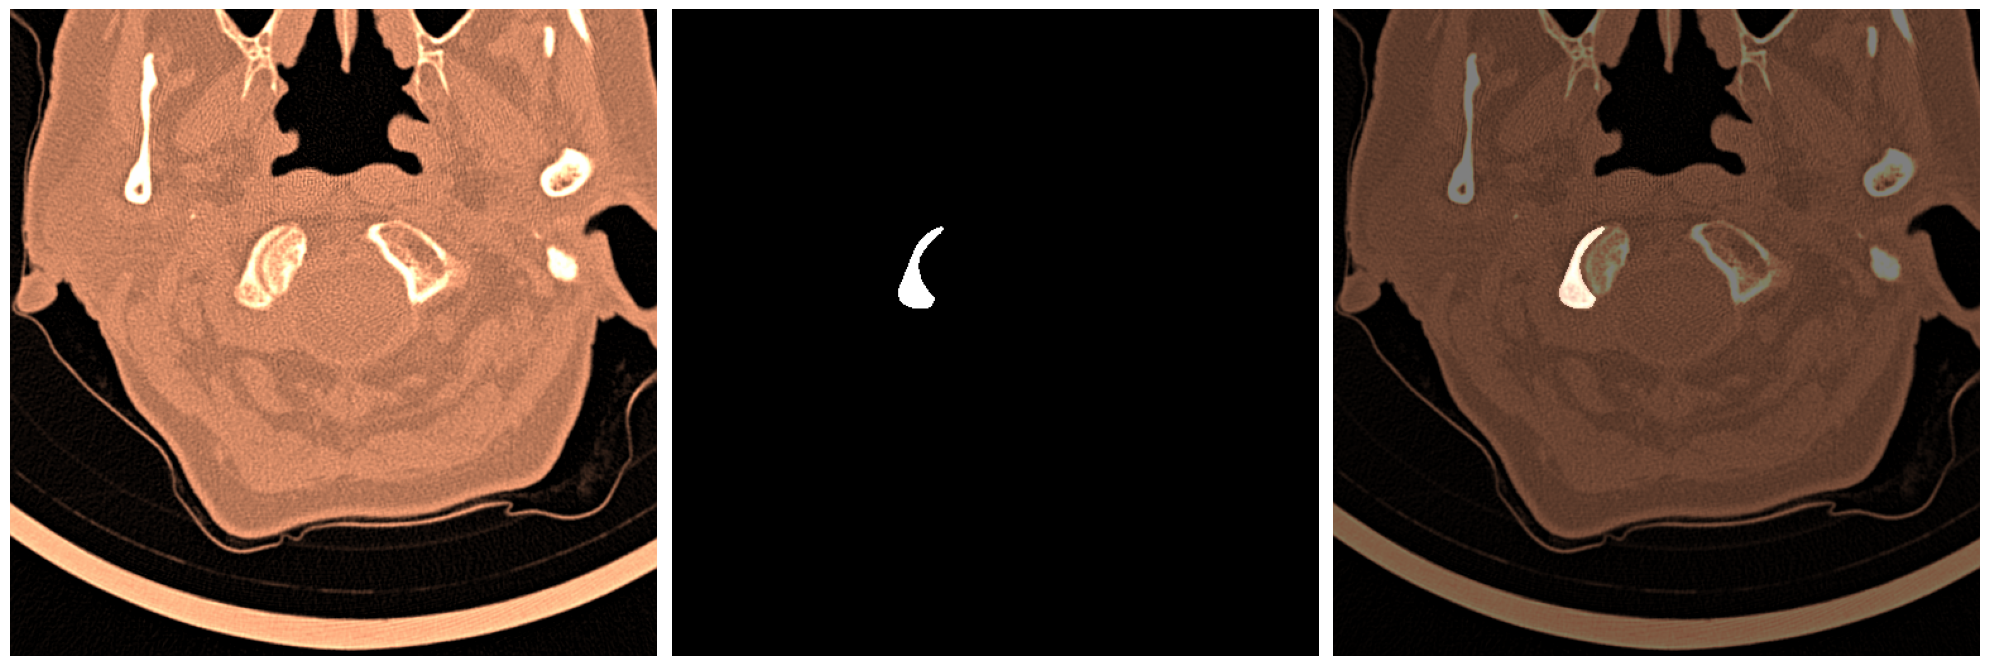

In [11]:
UID = '1.2.826.0.1.3680043.10633'
path_train = glob(f'{train_path}/{UID}/*')
path_seg = f'{segmentation_path}/{UID}.nii'

# convert train images
image = load_dicom(path_train)
# convert segmentation images
mask = load_nii(path_seg, UID, 3) # channel 3 to test printing
print_img(image, mask)

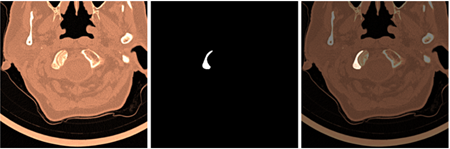

### Save Numpy Files

In [14]:
for idx in tqdm(range(len(train_df))):
    UID = train_df['StudyInstanceUID'][idx]
    
    if UID == '1.2.826.0.1.3680043.3130':
        path_train = glob(f'{train_path}/{UID}/*')
        try:
            # convert train images
            image = load_dicom(path_train)
        except ValueError:
            print(f'{UID}_{idx}')

        for idx in range(len(image)):
            each_save_path = save_path + f'/{UID}_{idx}.npz'
            with open(f'{each_save_path}', 'wb') as f:
                np.savez_compressed(f, image[idx])
    
    else: pass

100%|██████████| 2019/2019 [00:34<00:00, 58.34it/s]
